# Gradient Boosting Trees

**Ensemble learning** using **gradients**.

Regression using the [Boston House Prices](https://www.kaggle.com/c/boston-housing) dataset.

In [1]:
%config IPCompleter.greedy = True

## Importing Required Packages

In [7]:
# Package for data manipulation using DataFrames.
import pandas as pd

# A complex library for numerical computation. It is one of the most used Python packaged. It deals
# with N-dimensional arrays (vectors/matrices/tensors) and provides basic as well as advanced
# routines to compute with them.
import numpy as np

# A comprehensive package with a great deal of functionalities for plotting charts. Its interface
# is similar to that of Maplab's.
import matplotlib.pyplot as plt

# A decision tree for the regression task.
from sklearn.tree import DecisionTreeRegressor

# Boston House Prices dataset.
from sklearn.datasets import load_boston

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Evaluation metrics: accuracy, precision, recall.
from sklearn.metrics import accuracy_score

# Packages required for model visualization.
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus

In [3]:
# Auxiliary function for creating plots of tree diagrams.
def draw_tree_graph(model, feature_names, target_names):
    dot_data = StringIO()
    export_graphviz(
        model,
        out_file=dot_data, 
        filled=True,
        rounded=True,
        special_characters=True,
        feature_names=feature_names,
        class_names=target_names
    )
    return pydotplus.graph_from_dot_data(dot_data.getvalue())

For demonstration purposes, we only select a small subset of the data (e.g., $8$) to easily show the progress of our training.

In [4]:
n_samples = 8 #@param {type:"slider", min:1, max:16, step:1}

## Dataset Loading

In [8]:
feature_cols = [
    'CRIM',
    'RM',
    'DIS',
    'PTRATIO',
]
target_col = 'PRICE'

data = load_boston()
all_data_df = pd.DataFrame(data=data.data, columns=data.feature_names)
all_data_df[target_col] = data.target
all_data_df.shape

(506, 14)

In [9]:
data_df = all_data_df[feature_cols + [target_col]][:n_samples].copy()
data_df.shape

(8, 5)

## Dataset Preview

Here we show some basic information about our dataset.

In [10]:
data_df

CRIM     RM     DIS  PTRATIO  PRICE
0  0.00632  6.575  4.0900     15.3   24.0
1  0.02731  6.421  4.9671     17.8   21.6
2  0.02729  7.185  4.9671     17.8   34.7
3  0.03237  6.998  6.0622     18.7   33.4
4  0.06905  7.147  6.0622     18.7   36.2
5  0.02985  6.430  6.0622     18.7   28.7
6  0.08829  6.012  5.5605     15.2   22.9
7  0.14455  6.172  5.9505     15.2   27.1

Explanation of the **chosen columns** (features) in our dataset:
* **crim**: *per capita crime rate by town*,
* **rm**: *average number of rooms per dwelling*,
* **dis**: *weighted mean of distances to five Boston employment centres*,
* **ptratio**: *pupil-teacher ratio by town*,
* **price** (*original* **medv**): *median value of owner-occupied homes in $\$1000$s*.

In [11]:
X, y = data_df[feature_cols], data_df[target_col]

print(f"""X data shape: {X.shape}
y data shape: {y.shape}""")

X data shape: (8, 4)
y data shape: (8,)


## Gradient Boosting Algorithm

Now, we describe and demonstrate individual steps of the **gradient boosting** algorithm. The algorithm involves plenty of computation, yet it is not very complicated. We find it better to guide the student through individual steps with the text documentation and the code simultaneously.

For simplicity, assume just the following hyperparameters:
* **learning rate** (alpha - $\alpha$) - the rate by which the model is updated at learning steps,
* **no of. estimators** - a number of trees to be created (ensemble),
* **loss function** - objective/cost function $\to$ we choose quadratic function (i.e., a **squared loss**).

*Note: there are slight differences in the semantics of loss, objective, or cost function. We will not dive into the details here. We consistently use the term **loss function**. We provided the other two notions to remind that we mean something similar the student might have some prior knowledge about already.*

In [12]:
alpha = 0.1 #@param {type:"slider", min:0, max:2, step:0.01}

In [13]:
n_estimators = 20 #@param {type:"slider", min:1, max:100, step:1}

### Initialization

Assume the **dataset** in the form of $\left\{ \left( x_i, y_i \right) \right\}_{i = 1}^{n}$ and a **differentiable** loss function $\mathcal{L} \left( y_i, F \left( x \right) \right)$.

We will employ the **squared loss function** defined as
$$\mathcal{L} \left( y_i, F \left( x \right) \right) = \frac{1}{2} \left( y_i - F \left( x \right) \right)^2.$$

Now, **initialize** the model with a constant computed by the expression below:

$$F_0 \left( x \right) = \underset{\lambda}{\text{argmin}} \ \mathcal{L} \left( y_i, \lambda \right).$$

***

In our case, we compute the **average value** of a given **feature** that we want to use for regression, specifically, the column `PRICE`.

At this point, the task is to find such a value $\lambda$ that **minimizes the sum of quadratic errors between the predicted and the desired values**.

***

Now we show mathematically that the **arithmetic mean** of such values is the so-called **maximum likelihood estimator**, which makes it the optimal choice in our context.

Consider a list of values $y_1, y_2, \dots, y_n$ and a parameter $\lambda$. Our objective is to determine the value of $\lambda$ such that the expression

$$\mathcal{L} = \sum_{i = 1}^{n} \frac{1}{2} {\left( y_i - \lambda \right)}^2,$$

is **minimized**.

To find the **extremes** (i.e., minimum or maximum) of the function $\mathcal{L}$, we take its first derivative with respect to the variable that we use for optimization and solve for which point it evaluates to $0$. In other words, we have the following equality

$$\frac{\partial \mathcal{L}}{\partial \lambda} = 0.$$

We start by expanding the function definition, so we get

$$\frac{\partial \left[ \frac{1}{2} {\left( y_1 - \lambda \right)}^2 + \frac{1}{2} {\left( y_2 - \lambda \right)}^2 + \dots + \frac{1}{2} {\left( y_n - \lambda \right)}^2 \right]}{\partial \lambda} = 0.$$

We apply the derivative to individual terms, because it is a linear operator, i.e.,

$$\frac{\partial \left[ f \left( x \right) + g \left( x \right) \right]}{\partial x} = \frac{\partial f \left( x \right)}{\partial x} + \frac{\partial g \left( x \right)}{\partial x},$$

which transforms our equality into

$$\frac{\partial \left[ \frac{1}{2} {\left( y_1 - \lambda \right)}^2 \right]}{\partial \lambda} + \frac{\partial \left[ \frac{1}{2} {\left( y_2 - \lambda \right)}^2 \right]}{\partial \lambda} + \dots + \frac{\partial \left[ \frac{1}{2} {\left( y_n - \lambda \right)}^2 \right]}{\partial \lambda} = 0.$$

We take the derivatives above, which yields

$$\left( y_1 - \lambda \right) + \left( y_2 - \lambda \right) + \dots + \left( y_n - \lambda \right) = 0.$$

We may observe that the $\frac{1}{2}$ coefficients vanished from the equation. It is not a coincidence. It is one of the reasons they were used in the formulation in the first place, that is, to make the optimization less computationally expensive, yet without changing the position of extreme points. Remember that multiplying an objective/cost/loss function by a non-zero constant does not change the position of extreme points, only the function value at them. We proceed further with algebraic manipulations to obtain the following progression of equations:

$$ y_1 - \lambda + y_2 - \lambda + \dots + y_n - \lambda = 0$$
$$ -n\lambda + y_1 + y_2 + \dots + y_n = 0$$
$$ -n\lambda = -y_1 - y_2 - \dots - y_n$$
$$ n\lambda = y_1 + y_2 + \dots + y_n$$
$$ \lambda = \frac{y_1 + y_2 + \dots + y_n}{n} = \frac{1}{n} \sum_{i = 1}^{n} y_i,$$

which is an **arithmetic mean** is the values $y_1, y_2, \dots, y_n$. Thus, the optimal value of $\lambda$ is the arithmetic mean, which justifies our initial statement. $\quad\blacksquare$



### Loss Function Visualization

A demonstration that the **arithmetic mean** of the values for the function defined as the **sum of squared residuals** (quadratic error) is the **global minimum**.

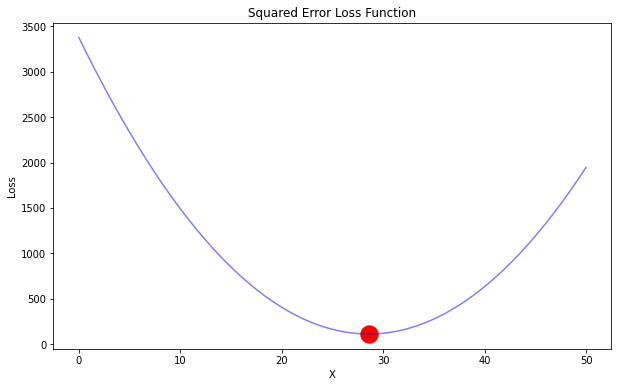

In [19]:
def loss_se(x):
    return np.sum(0.5 * (data_df[target_col] - x) ** 2)

xs = np.linspace(0, 50, 300)
ys = np.apply_along_axis(loss_se, 1, xs[:, None])

x_min = np.mean(data_df[target_col])
y_min = loss_se(x_min)

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, alpha=0.5, c='blue')
plt.scatter(x_min, y_min, s=300, c='red')
plt.title("Squared Error Loss Function")
plt.xlabel("X")
plt.ylabel("Loss")
plt.show()

We can see that the **arithmetic mean** does indeed correspond to the point at which the function reaches its **global minimum**. This solution is the global minimum thanks to the fact that our function is **convex**. Moreover, the extremal points can easily be obtained using a simple **explicit analytical approach**, rather than a computationally expensive numerical approach.

***

Here we create a **2D array** that will store all the **predictions** in individual **iterations**. The **number of rows** equals `n_estimators + 1` since the initial prediction is the **arithmetic mean**, which counts as the zeroth iteration.


In [14]:
preds = np.zeros((n_estimators + 1, len(data_df[target_col])))
preds.shape

(21, 8)

Here we create a **2D array** that contains all **residuals** computed in individual **iterations**. The number of columns is the same as in the case of the array for the **number of predictions** since we deal with **deviations** of predictions from the desired values. The number of rows is equal to the number of estimators.

In [15]:
residuals = np.zeros((n_estimators, len(data_df[target_col])))
residuals.shape

(20, 8)

An **array** of single **trees** (**estimators** / **regressors**).

In [16]:
trees = []  # The final size will be equal to the number of estimators.

Now we compute the **initial prediction**. We use the **arithmetic mean** for each sample in the dataset.

In [18]:
preds[0] = np.full_like(data_df[target_col], np.mean(data_df[target_col]))
preds[0]

array([28.575, 28.575, 28.575, 28.575, 28.575, 28.575, 28.575, 28.575])

### First Iteration

**Repeat** for $t = 1 \to T$:
* Compute $r_{it} = -\left[ \frac{\partial \mathcal{L} \left( y_i, F \left( x_i \right) \right)}{\partial F \left( x_i \right)} \right]_{F \left( x \right) = F_{t - 1} \left( x \right)},$ for $i = 1, \dots, n$. The notation $r_{it}$ means **residual** for $i$-th row of the dataset and the $t$-th tree (estimator). The loop $1, \dots, n$ represents a computation for the entire dataset.


In [20]:
t = 1

In [21]:
# Compute t - 1 due to zero-based indexing.
residuals[t - 1] = data_df[target_col] - preds[0]  # A computation of residuals.
residuals[t - 1]

array([-4.575, -6.975,  6.125,  4.825,  7.625,  0.125, -5.675, -1.475])

* Create a **regression tree** using the **residual values**, $r_{it}$, for $i = 1, \dots, n$. We assume that the $t$-th tree containts $J_t$ leaves. Each leaf of the $t$-th tree will be referred to by the index $j$, for $j = 1, \dots, J_t$.

***

In this step, we create the tree as usual, but the **dependent variable** is not the `PRICE` but the **computed residuals**.

In [22]:
tree = DecisionTreeRegressor(max_depth=2)  # For simplicity, use a small tree.
tree.fit(X, residuals[t - 1])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [23]:
trees.append(tree)  # Add the newly built tree into the list.

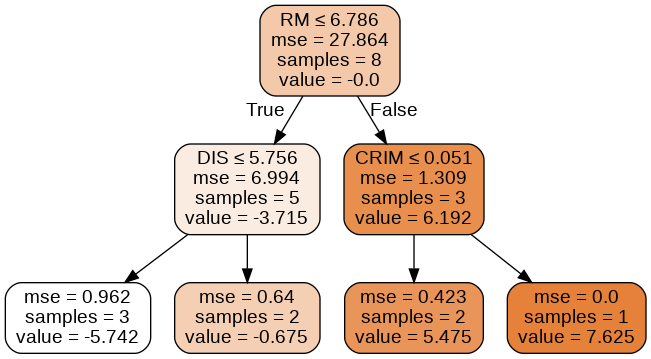

In [24]:
graph = draw_tree_graph(tree, feature_cols, [target_col])
Image(graph.create_png())

* For $j = 1, \dots, J_t$ compute
$$\lambda_{jm} = \underset{\lambda}{\text{argmin}} \sum_{x_i \in R_{ij}} \mathcal{L} \left( y_i, F_{t - 1} \left( x_i \right) + \lambda \right).$$

***

This step means that for all the values that ended up in one of the leaves of our "ancillary" $t$-th tree, compute their arithmetic mean in a given region and use the resulting value as a prediction.

The trivial arithmetic mean is computed only because of the used **loss function** for which it is the **maximum likelihood estimator**, as shown above.

The class `DecisionTreeRegressor` uses the arithmetic mean by default.

* Update

$$F_{t} \left( x \right) = F_{t - 1} \left( x \right) + \alpha \sum_{j = 1}^{J_t} \lambda_{jt} I \left(x \in R_{jt} \right)$$

***

The sum represents the **summation of predictions across all leaves**, in which the sample $x$ has been found.

The **learning rate** is determined by the coefficient $\alpha$. It usually equals $0.1$.

In [25]:
preds[t] = preds[t - 1] + alpha * tree.predict(X)
preds[t]

array([28.00083333, 28.00083333, 29.1225    , 29.1225    , 29.3375    ,
       28.5075    , 28.00083333, 28.5075    ])

In [26]:
t += 1  # Proceed to the next tree.

### Remaining Iterations

From now on, we will continue as we have shown above. The first iteration is complete. All the previously described steps will repeat multiple times.

***

### Task 1

> Based on the first iteration shown above, **implement the remaining iterations** to the code provided below.

In [27]:
while t <= n_estimators:  # Finish the remaining iterations.
    residuals[t - 1] = data_df[target_col] - preds[t - 1]
    tree = DecisionTreeRegressor(max_depth=2)  # Use a small tree for simplicity.
    tree.fit(X, residuals[t - 1])
    preds[t] = preds[t - 1] + alpha * tree.predict(X)
    trees.append(tree)  # Add the current tree to the list.
    t += 1  # Procees to the next tree.

## Final Model

* The **output** of our algorithm (the final model)  for **new predictions** is the value $F_{T} \left( x \right)$.

## Visualizing Iterations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


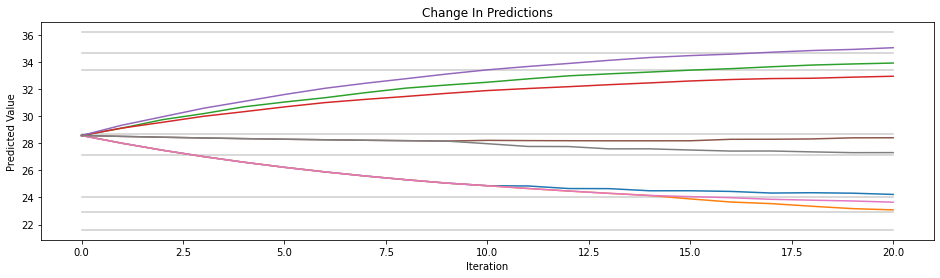

In [28]:
targets = np.repeat(data_df[target_col][:, None], n_estimators + 1, axis=1).T

plt.figure(figsize=(16, 4))
plt.plot(targets, c='black', alpha=0.2)
plt.plot(preds)
plt.title("Change In Predictions")
plt.xlabel("Iteration")
plt.ylabel("Predicted Value")
plt.show()

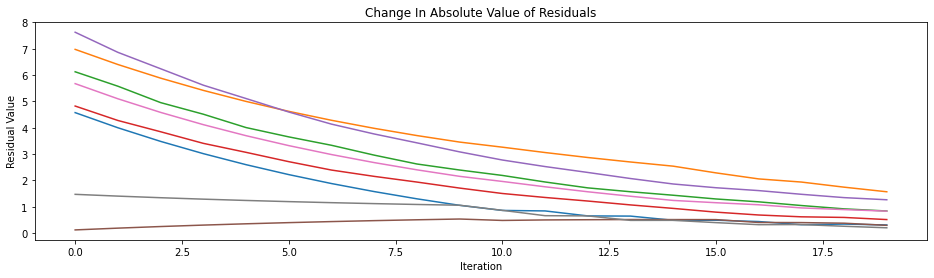

In [29]:
plt.figure(figsize=(16, 4))
plt.plot(np.abs(residuals))
plt.title("Change In Absolute Value of Residuals")
plt.xlabel("Iteration")
plt.ylabel("Residual Value")
plt.show()

## Making New Predictions

### Task 2

> **Implement** a code to **make a new prediction** for supplied values.
>
> Tasks:
> * **2.1)** **Finlize the implementation** of the function `gbrt_predict(trees, alpha, init_val, x)`, which uses the created **GBRT** model to make the prediction. For simplicity, assume that there is only one sample on the input.
> * **2.2)** **Implement prediction** for the following data sample:
>     * **crim**: *per capita crime rate by town* = $0.10959$,
>     * **rm**: *average number of rooms per dwelling* = $6.794$,
>     * **dis**: *weighted mean of distances to five Boston employment centres* = $2.3889$,
>     * **ptratio**: *pupil-teacher ratio by town* = $21.0$, 
***

In [30]:
# Solution to the task 2.1:
def gbrt_predict(trees, alpha, init_val, x):
    return init_val + sum(map(lambda t: alpha * t.predict([x])[0], trees))

In [31]:
# Solution to the task 2.2:
custom_data = np.float32([0.10959, 6.794, 2.3889, 21.0])
gbrt_predict(trees, alpha, preds[0][0], custom_data)

34.083110291875194